In [1]:
#Import libraries
import pandas as pd
import numpy as np
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# ---------------------------------------------------------------------------

#Bayesian optimization
def bayesian_optimization(dataset, function, parameters):
    X_train, y_train, X_test, y_test = dataset
    n_iterations = 5
    gp_params = {"alpha": 1e-4}

    BO = BayesianOptimization(function, parameters)
    BO.maximize(n_iter=n_iterations, **gp_params)

    return BO.max
# --------------------------------------------------------------------------- 

# ---------------------------------------------------------------------------


# ---------------------------------------------------------------------------

#Train model
# def train(X_train, y_train, X_test, y_test, function, parameters):
#     dataset = (X_train, y_train, X_test, y_test)
#     cv_splits = 4
    
#     best_solution = bayesian_optimization(dataset, function, parameters)      
#     params = best_solution["params"]

#     model = RandomForestClassifier(
#              n_estimators=int(max(params["n_estimators"], 0)),
#              max_depth=int(max(params["max_depth"], 1)),
#              min_samples_split=int(max(params["min_samples_split"], 2)), 
#              n_jobs=-1, 
#              random_state=42,   
#              class_weight="balanced")

#     model.fit(X_train, y_train)
    
#     return model    

In [2]:
from Preprocess import *
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn import model_selection as ms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score,precision_recall_fscore_support,classification_report
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Logistic regression
# X, Y = get_data('diabetic_data.csv',labelEncode=False,hotEncode=True, skewness=True, standardize = False)
# Random forest & XGB
X, Y = get_data('diabetic_data.csv',labelEncode=True,hotEncode=False, skewness=False, standardize = True)

Original data shape (101766, 50)
Process Missing data
Delete multipule encounters
Transform features
Standardize numeric columns
Conduce label encoding
Data shape after preprocessing: (69973, 43)


In [344]:
pd.set_option('display.max_columns', 50)
X.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,diag_1_group,diag_2_group,diag_3_group
0,2,0,5,1,0,0,1.270247,1.715256,2.603390,2.091752,-0.262715,-0.203005,-0.292949,0.387868,2,2,2,1,1,1,1,0,1,0,0,1,1,0,1,0,0,2,1,0,0,0,0,0,1,0,3,1
1,2,0,5,2,0,0,-0.774811,0.307824,-0.242178,-0.562948,-0.262715,-0.203005,-0.292949,-2.110458,2,2,1,1,1,1,1,0,1,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,5,7,1
2,2,0,8,0,14,14,-0.093125,1.262867,0.326935,0.885070,-0.262715,-0.203005,-0.292949,0.887534,2,0,2,1,1,1,1,0,1,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,3,8,7
3,2,0,8,0,0,14,-0.433968,0.157027,-0.811292,0.523066,-0.262715,-0.203005,-0.292949,0.887534,2,1,2,1,1,1,1,0,1,2,0,1,1,0,1,0,0,1,1,0,0,0,0,0,1,7,0,0
4,0,0,3,0,0,14,0.247718,0.307824,-0.811292,-1.286957,-0.262715,-0.203005,-0.292949,-2.110458,2,2,1,1,1,1,2,0,1,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,2,6,1


# Train test split

In [41]:
x_train, x_test, y_train, y_test = ms.train_test_split(X, Y,test_size=0.2, random_state=0)
print('Readmission ratio for processed data : {}'.format(len(Y[Y==1])/len(Y)))
print('Readmission ratio for training data and data size: {}, {}'.format(len(y_train[y_train==1])/len(y_train),len(y_train)))
print('Readmission ratio for test data and data size: {}, {}'.format(len(y_test[y_test==1])/len(y_test),len(y_test)))
x_train_o = x_train
x_test_o = x_test
y_train_o = y_train
y_test_o = y_test

Readmission ratio for processed data : 0.08970602946850928
Readmission ratio for training data and data size: 0.08964235949837436, 55978
Readmission ratio for test data and data size: 0.08996070025008931, 13995


# Resampling — Oversample minority class

In [30]:
# Concatenate training data back together
X_up = pd.concat([x_train, y_train], axis=1)

# separate minority and majority classes
not_readmitted = X_up[X_up.readmitted==0]
readmitted = X_up[X_up.readmitted==1]

# upsample minority
readmit_upsampled = resample(readmitted,
                             replace=True, # sample with replacement
                             n_samples=int(1*len(not_readmitted)), # match number in majority class
                             random_state=1) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_readmitted, readmit_upsampled])

# check new class counts
print(upsampled.readmitted.value_counts())

y_train_up = upsampled['readmitted']
x_train_up = upsampled.drop('readmitted',1)

1    50960
0    50960
Name: readmitted, dtype: int64


# Resampling techniques — Undersample majority class

In [42]:
# Concatenate training data back together
X_down = pd.concat([x_train, y_train], axis=1)

# separate minority and majority classes
not_readmitted = X_down[X_down.readmitted==0]
readmitted = X_down[X_down.readmitted==1]

# downsample majority
not_readmit_downsampled = resample(not_readmitted,
                                     replace = False, # sample without replacement
                                     n_samples = int(1*len(readmitted)), # match minority n
                                     random_state = 1) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_readmit_downsampled, readmitted])

# checking counts
print(downsampled.readmitted.value_counts())

y_train_down = downsampled['readmitted']
x_train_down = downsampled.drop('readmitted',1)

1    5018
0    5018
Name: readmitted, dtype: int64


# Synthetic Minority Oversampling Technique (SMOTE)

In [31]:
smo = SMOTE(random_state=1, ratio=1)
x_train_smo, y_train_smo = smo.fit_sample(x_train, y_train)

# check new class counts
print(pd.Series(y_train_smo).value_counts())

1    50960
0    50960
dtype: int64


# Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
LR_up = LogisticRegression(class_weight='balanced')
LR_smo = LogisticRegression(class_weight='balanced')
LR_up.fit(x_train_up, y_train_up)
y_predict_up = LR_up.predict(x_test)
LR_smo.fit(x_train_smo, y_train_smo)
y_predict_smo = LR_smo.predict(x_test)
print('Train score use over-sampling: {}'.format(LR_up.score(x_train_up, y_train_up)))
print('Test score use over-sampling: {}'.format(LR_up.score(x_test, y_test)))
print('Train score use SMOTE: {}'.format(LR_smo.score(x_train_smo, y_train_smo)))
print('Test score use SMOTE: {}'.format(LR_smo.score(x_test, y_test)))

Train score use over-sampling: 0.6132358712715855
Test score use over-sampling: 0.6563058235083958
Train score use SMOTE: 0.636734693877551
Test score use SMOTE: 0.6382993926402286


In [33]:
confusion_matrix(y_test,y_predict_up)

array([[8485, 4251],
       [ 559,  700]])

In [34]:
confusion_matrix(y_test,y_predict_smo)

array([[8242, 4494],
       [ 568,  691]])

In [35]:
print(classification_report(y_test,y_predict_smo))

              precision    recall  f1-score   support

           0       0.94      0.65      0.77     12736
           1       0.13      0.55      0.21      1259

    accuracy                           0.64     13995
   macro avg       0.53      0.60      0.49     13995
weighted avg       0.86      0.64      0.72     13995



### K-fold

In [11]:
LR_up.set_params(C=1e1,penalty='l2')
LR_smo.set_params(C=1e1,penalty='l2')
stratify_divide = ms.StratifiedKFold(n_splits=5, random_state=0)
scores_up = ms.cross_val_score(estimator=LR_up, X=x_train_up, y=y_train_up, cv=stratify_divide)
scores_smo = ms.cross_val_score(estimator=LR_smo, X=x_train_smo, y=y_train_smo, cv=stratify_divide)
print('Train score use over-sampling: {}'.format(scores_up.mean()))
print('Train score use SMOTE: {}'.format(scores_smo.mean()))

Train score use over-sampling: 0.6071428571428571
Train score use SMOTE: 0.6309262166405023


In [375]:
LR_up.set_params(C=1e1,penalty='l1')
LR_smo.set_params(C=1e1,penalty='l1')
stratify_divide = ms.StratifiedKFold(n_splits=9, random_state=0)
scores_up = ms.cross_val_score(estimator=LR_up, X=x_train_up, y=y_train_up, cv=stratify_divide)
scores_smo = ms.cross_val_score(estimator=LR_smo, X=x_train_smo, y=y_train_smo, cv=stratify_divide)
print('Train score use over-sampling: {}'.format(scores_up.mean()))
print('Train score use SMOTE: {}'.format(scores_smo.mean()))

Train score use over-sampling: 0.6068975917448527
Train score use SMOTE: 0.6308776638476644


In [16]:
pd.DataFrame(LR_smo.coef_[0],index=x_train.columns,columns=['Importance'])\
    .sort_values('Importance',ascending=False).head(10)

,Importance
discharge_disposition_id_15,2.341466
discharge_disposition_id_28,1.738151
discharge_disposition_id_22,1.632463
discharge_disposition_id_9,1.435135
discharge_disposition_id_5,1.217489
number_inpatient,1.128468
acarbose_Up,0.624680
admission_type_id_4,0.567916
discharge_disposition_id_3,0.543740
diag_1_group_Missing,0.474473


In [17]:
pd.DataFrame(LR_smo.coef_[0],index=x_train.columns,columns=['Importance'])\
    .sort_values('Importance',ascending=True).head(10)

,Importance
rosiglitazone_Down,-2.307921
tolbutamide_Steady,-2.232267
admission_type_id_7,-1.883906
nateglinide_Up,-1.608723
admission_source_id_8,-1.434375
nateglinide_Down,-1.431949
discharge_disposition_id_10,-1.429503
tolazamide_Steady,-1.390383
repaglinide_Down,-1.332498
miglitol_Steady,-1.311471


In [13]:
def quan_tab(model,x,y,cut=10):
    readmit_prob = [i[1] for i in model.predict_proba(x)]
    quantile_ = pd.qcut(readmit_prob,cut,labels=np.arange(1,cut+1))
    temp_dict = {'quantile':quantile_,'prob':readmit_prob,'Readmitted':y}
    quan_table = pd.DataFrame(temp_dict).sort_values('quantile')
    temp1 = quan_table.groupby('quantile')['prob'].agg(['count','min','max']).reset_index()
    temp2 = quan_table.groupby(['quantile','Readmitted']).count().reset_index()
    temp2 = temp2[temp2.Readmitted==1]
    quan_table = pd.merge(temp2, temp1, how='inner',on ='quantile').drop('Readmitted',1).\
                    rename({'prob': 'readmitted','count':'amount'}, axis=1)
    quan_table = quan_table[quan_table.columns[[0,2,1,3,4]]]
    quan_table['pct_readmitted'] = quan_table.readmitted/quan_table.amount
    quan_table['lift'] = quan_table.pct_readmitted.apply(lambda x:10*x/quan_table.pct_readmitted.sum())
    return quan_table

In [376]:
quan_table = quan_tab(LR_smo,x_test,y_test)

In [377]:
quan_table

,quantile,amount,readmitted,min,max,pct_readmitted,lift
0,1,1400,59,0.020515,0.266838,0.042143,0.468467
1,2,1399,85,0.266981,0.321460,0.060758,0.675392
2,3,1400,80,0.321589,0.364460,0.057143,0.635209
3,4,1399,99,0.364552,0.404255,0.070765,0.786633
4,5,1400,107,0.404276,0.444452,0.076429,0.849592
5,6,1399,114,0.444538,0.485632,0.081487,0.905820
6,7,1399,133,0.485659,0.531294,0.095068,1.056790
7,8,1400,125,0.531315,0.590009,0.089286,0.992514
8,9,1399,168,0.590103,0.672170,0.120086,1.334892
9,10,1400,289,0.672222,0.971260,0.206429,2.294692


In [49]:
print(LR_GS.best_params_)
print(LR_GS.best_score_)

{'C': 0.1}
0.6558648040301547


# Random Forest

In [6]:
def rfc_optimization(cv_splits):
    def function(n_estimators, max_depth, min_samples_split):
        return cross_val_score(
               RandomForestClassifier(
                   n_estimators=int(max(n_estimators,0)),                                                               
                   max_depth=int(max(max_depth,1)),
                   min_samples_split=int(max(min_samples_split,2)), 
                   n_jobs=-1, 
                   random_state=42,   
                   class_weight="balanced"),  
               X=X_train, 
               y=y_train, 
               cv=cv_splits,
               scoring="roc_auc",
               n_jobs=-1).mean()

    parameters = {"n_estimators": (10, 1000),
                  "max_depth": (1, 150),
                  "min_samples_split": (2, 10)}
    
    return function, parameters  

def train(X_train, y_train, X_test, y_test, function, parameters):
    dataset = (X_train, y_train, X_test, y_test)
    cv_splits = 4
    
    best_solution = bayesian_optimization(dataset, function, parameters)      
    params = best_solution["params"]

    model = RandomForestClassifier(
             n_estimators=int(max(params["n_estimators"], 0)),
             max_depth=int(max(params["max_depth"], 1)),
             min_samples_split=int(max(params["min_samples_split"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

    model.fit(X_train, y_train)
    
    return model 

In [7]:
func, para = rfc_optimization(5)
X_train = x_train_down
y_train = y_train_down
X_test = x_test

In [8]:
rf_opt = train(X_train, y_train, X_test, y_test, func, para)

|   iter    |  target   | max_depth | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.6274   |  23.56    |  5.142    |  463.6    |
|  2        |  0.6286   |  91.09    |  8.599    |  284.0    |
|  3        |  0.6313   |  100.6    |  9.137    |  904.5    |
|  4        |  0.6271   |  121.6    |  2.975    |  806.5    |
|  5        |  0.63     |  5.812    |  4.491    |  698.6    |
|  6        |  0.5843   |  148.7    |  3.561    |  10.47    |
|  7        |  0.6204   |  1.304    |  7.074    |  998.7    |
|  8        |  0.6204   |  1.819    |  5.822    |  999.1    |
|  9        |  0.6295   |  148.6    |  7.597    |  999.5    |
|  10       |  0.6303   |  149.7    |  6.222    |  1e+03    |


In [9]:
y_pr_rf = rf_opt.predict(x_test)
print('Train score: {}'.format(rf_opt.score(X_train, y_train)))
print('Test score: {}'.format(rf_opt.score(x_test, y_test)))

Train score: 0.9929254683140694
Test score: 0.5992140050017863


In [10]:
confusion_matrix(y_test,y_pr_rf)

array([[7618, 5118],
       [ 491,  768]])

In [11]:
precision_recall_fscore_support(y_test,y_pr_rf)
# Output is:
# [Precision of class 0, Precision of class 1]
# [Recall of class 0   , Recall of class 1]
# [F1 Score of class 0 , F1 Score of class 1]
# [Instances of class 0, Instances of class 1]

(array([0.93944999, 0.1304791 ]),
 array([0.59814698, 0.61000794]),
 array([0.73091869, 0.21497551]),
 array([12736,  1259]))

In [14]:
quantile_table_RF = quan_tab(rf_opt,x_test,y_test)
quantile_table_RF

,quantile,amount,readmitted,min,max,pct_readmitted,lift
0,1,1400,51,0.101228,0.337221,0.036429,0.404951
1,2,1399,67,0.337271,0.381814,0.047891,0.532374
2,3,1400,89,0.381821,0.415412,0.063571,0.706679
3,4,1399,88,0.415417,0.445722,0.062902,0.699238
4,5,1400,103,0.445726,0.476695,0.073571,0.817842
5,6,1399,114,0.476745,0.505696,0.081487,0.905831
6,7,1399,124,0.505704,0.536228,0.088635,0.985290
7,8,1400,163,0.536247,0.571302,0.116429,1.294254
8,9,1399,184,0.571312,0.617152,0.131523,1.462043
9,10,1400,276,0.617160,0.883116,0.197143,2.191498


In [15]:
print(classification_report(y_test,y_pr_rf))

              precision    recall  f1-score   support

           0       0.94      0.60      0.73     12736
           1       0.13      0.61      0.21      1259

    accuracy                           0.60     13995
   macro avg       0.53      0.60      0.47     13995
weighted avg       0.87      0.60      0.68     13995



# XGB

In [16]:
def xgb_optimization(cv_splits, eval_set):
    def function(eta, gamma, max_depth):
            return cross_val_score(
                   xgb.XGBClassifier(
                       objective="binary:logistic",
                       learning_rate=max(eta, 0),
                       gamma=max(gamma, 0),
                       max_depth=int(max_depth),                                               
                       seed=42,
                       nthread=-1,
                       scale_pos_weight = len(y_train[y_train == 0])/
                                          len(y_train[y_train == 1])),  
                   X=X_train, 
                   y=y_train, 
                   cv=cv_splits,
                   scoring="roc_auc",
                   fit_params={
                        "early_stopping_rounds": 10, 
                        "eval_metric": "auc", 
                        "eval_set": eval_set},
                   n_jobs=-1).mean()

    parameters = {"eta": (0.001, 0.4),
                  "gamma": (0, 20),
                  "max_depth": (1, 2000)}
    
    return function, parameters

# def train(X_train, y_train, X_test, y_test, function, parameters):
#     dataset = (X_train, y_train, X_test, y_test)
#     cv_splits = 4
    
#     best_solution = bayesian_optimization(dataset, function, parameters)      
#     params = best_solution["params"]

#     model = RandomForestClassifier(
#              n_estimators=int(max(params["n_estimators"], 0)),
#              max_depth=int(max(params["max_depth"], 1)),
#              min_samples_split=int(max(params["min_samples_split"], 2)), 
#              n_jobs=-1, 
#              random_state=42,   
#              class_weight="balanced")

#     model.fit(X_train, y_train)
    
#     return model 

In [18]:
X_train = x_train_down
y_train = y_train_down
X_train, val_x, y_train, val_y = ms.train_test_split(X_train, y_train, test_size = 0.05, random_state=1)
X_train = x_train_down
y_train = y_train_down
X_test = x_test
func, para = xgb_optimization(5,[[val_x, val_y]])
dataset = (X_train, y_train, X_test, y_test)
cv_splits = 5

In [19]:
best_solution = bayesian_optimization(dataset, func, para)      
params = best_solution["params"]

|   iter    |  target   |    eta    |   gamma   | max_depth |
-------------------------------------------------------------
|  1        |  0.6337   |  0.2115   |  10.67    |  1.816e+0 |
|  2        |  0.6251   |  0.08734  |  19.54    |  16.15    |
|  3        |  0.6357   |  0.1094   |  10.57    |  1.298e+0 |
|  4        |  0.6237   |  0.2814   |  18.94    |  1.817e+0 |
|  5        |  0.6323   |  0.2489   |  10.7     |  621.1    |
|  6        |  0.5908   |  0.03854  |  0.6345   |  1.018    |
|  7        |  0.6271   |  0.2959   |  18.79    |  2e+03    |
|  8        |  0.6039   |  0.1374   |  1.375    |  2e+03    |
|  9        |  0.6208   |  0.112    |  19.99    |  1.063e+0 |
|  10       |  0.6241   |  0.04613  |  17.51    |  2e+03    |


In [21]:
xgb_opt = xgb.XGBClassifier(
             eta=max(params["eta"], 0),
             gamma=max(params["gamma"], 0),
             max_depth=int(max(params["max_depth"], 2)), 
             n_jobs=-1, 
             random_state=42,   
             class_weight="balanced")

In [22]:
X_train = x_train_down
y_train = y_train_down
xgb_opt.fit(x_train_down, y_train_down)

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.10935935143868462, gamma=10.572258411021911,
              learning_rate=0.1, max_delta_step=0, max_depth=1297,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [23]:
y_pr_xgb = xgb_opt.predict(x_test)
print('Train score: {}'.format(xgb_opt.score(x_train_o, y_train_o)))
print('Test score use: {}'.format(xgb_opt.score(x_test_o, y_test_o)))

Train score: 0.6148308263960842
Test score use: 0.6125044658806716


In [24]:
confusion_matrix(y_test,y_pr_xgb)

array([[7806, 4930],
       [ 493,  766]])

In [49]:
766/(766+493)

0.6084193804606831

In [25]:
precision_recall_fscore_support(y_test,y_pr_xgb)
# Output is:
# [Precision of class 0, Precision of class 1]
# [Recall of class 0   , Recall of class 1]
# [F1 Score of class 0 , F1 Score of class 1]
# [Instances of class 0, Instances of class 1]

(array([0.94059525, 0.13448034]),
 array([0.61290829, 0.60841938]),
 array([0.74219159, 0.22027318]),
 array([12736,  1259]))

In [26]:
quantile_table_xgb = quan_tab(xgb_opt,x_test,y_test)
quantile_table_xgb

,quantile,amount,readmitted,min,max,pct_readmitted,lift
0,1,1400,48,0.248544,0.347366,0.034286,0.381130
1,2,1399,70,0.347399,0.381916,0.050036,0.556211
2,3,1400,90,0.381932,0.409440,0.064286,0.714618
3,4,1399,94,0.409448,0.438297,0.067191,0.746912
4,5,1400,86,0.438301,0.470048,0.061429,0.682857
5,6,1399,109,0.470066,0.502020,0.077913,0.866101
6,7,1399,122,0.502032,0.529843,0.087205,0.969397
7,8,1400,154,0.529865,0.561207,0.110000,1.222791
8,9,1399,184,0.561220,0.609670,0.131523,1.462041
9,10,1400,302,0.609720,0.845351,0.215714,2.397941


In [379]:
print(classification_report(y_test,y_pr_xgb))

              precision    recall  f1-score   support

           0       0.94      0.62      0.74     12736
           1       0.14      0.61      0.22      1259

    accuracy                           0.62     13995
   macro avg       0.54      0.61      0.48     13995
weighted avg       0.87      0.62      0.70     13995



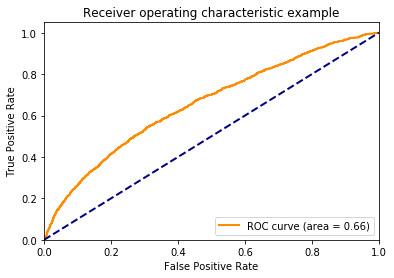

In [46]:
y_probs_xgb = pd.DataFrame(xgb_opt.predict_proba(x_test))[1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_xgb)
auc = roc_auc_score(y_test, y_probs_xgb)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw,
        label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ROC Curve

In [91]:
lbl = LabelEncoder() 
lbl.fit(list(y_test.values)) 
y_test = lbl.transform(list(y_test.values))

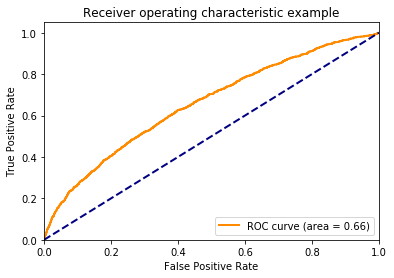

In [93]:
y_probs = pd.DataFrame(LR_up.predict_proba(x_test))[1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw,
        label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [29]:
y_hat = LR_up.predict(x_test)
precision_recall_fscore_support(y_test, y_hat)
# Output is:
# [Precision of class 0, Precision of class 1]
# [Recall of class 0   , Recall of class 1]
# [F1 Score of class 0 , F1 Score of class 1]
# [Instances of class 0, Instances of class 1]

(array([0.93752745, 0.14119091]),
 array([0.67046168, 0.54805401]),
 array([0.78181652, 0.22453628]),
 array([12736,  1259]))